KNN Regressor Performance Comparison (TF-IDF - Euclidean vs Cosine):
       K     Metric  Train_MSE  Train_R2  Train_MAE  Test_MSE   Test_R2  \
0      1  euclidean   0.000000  1.000000   0.000000  0.373515 -1.159842   
1      5  euclidean   0.043253  0.749564   0.163757  0.056859  0.671214   
2     10  euclidean   0.033772  0.804461   0.143004  0.039302  0.772736   
3     50  euclidean   0.039776  0.769693   0.149070  0.040937  0.763285   
4    100  euclidean   0.051161  0.703776   0.167273  0.052295  0.697603   
5    200  euclidean   0.066908  0.612601   0.191204  0.067829  0.607778   
6    500  euclidean   0.092632  0.463659   0.229566  0.092742  0.463722   
7   1000  euclidean   0.114894  0.334761   0.264210  0.114510  0.337847   
8      1     cosine   0.000087  0.999498   0.000097  0.095617  0.447097   
9      5     cosine   0.029660  0.828270   0.112421  0.043733  0.747117   
10    10     cosine   0.030672  0.822411   0.120175  0.036569  0.788539   
11    50     cosine   0.040813 

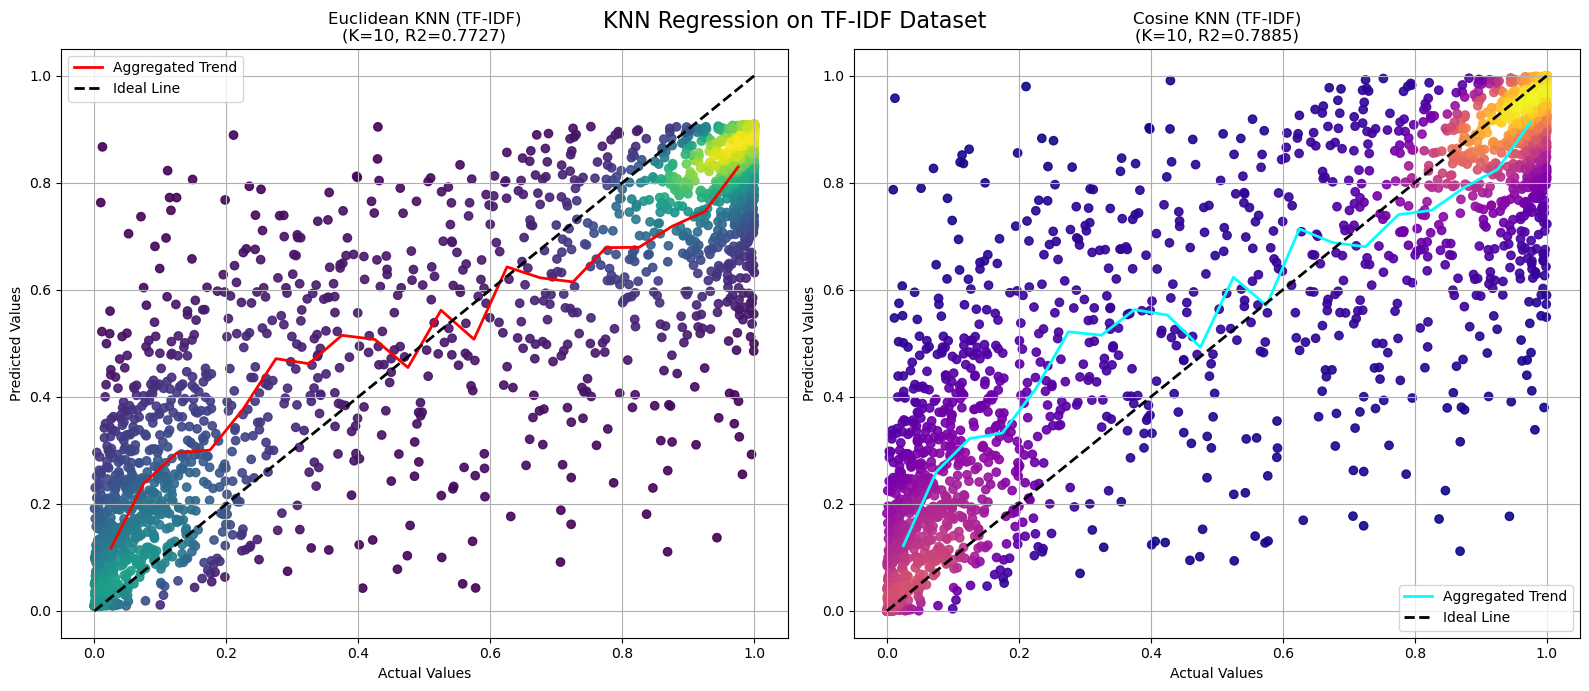

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load the dataset
data = pd.read_csv('tfidf_regression_dataset_logreg.csv')

# Define features and target
X = data.drop(columns=['Problematic_Rate'])
y = data['Problematic_Rate']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of K values to evaluate
k_values = [1, 5, 10, 50, 100, 200, 500, 1000]

# Initialize results dictionary
results = {
    'K': [], 'Metric': [], 'Train_MSE': [], 'Train_R2': [], 'Train_MAE': [],
    'Test_MSE': [], 'Test_R2': [], 'Test_MAE': [], 'Fit_Time': [], 'Test_Time': []
}

# Function to evaluate KNN for a given distance metric
def evaluate_knn(metric_name):
    best_r2 = -np.inf
    best_model = None
    best_predictions = None

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric_name)

        # Measure fit time
        start_fit = time.time()
        knn.fit(X_train, y_train)
        fit_time = time.time() - start_fit

        # Measure test time
        start_test = time.time()
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        test_time = time.time() - start_test

        # Calculate metrics for train and test sets
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Save results
        results['K'].append(k)
        results['Metric'].append(metric_name)
        results['Train_MSE'].append(train_mse)
        results['Train_R2'].append(train_r2)
        results['Train_MAE'].append(train_mae)
        results['Test_MSE'].append(test_mse)
        results['Test_R2'].append(test_r2)
        results['Test_MAE'].append(test_mae)
        results['Fit_Time'].append(fit_time)
        results['Test_Time'].append(test_time)

        # Track the best model
        if test_r2 > best_r2:
            best_r2 = test_r2
            best_model = knn
            best_predictions = y_test_pred

    return best_model, best_predictions

# Evaluate both Euclidean and Cosine KNN
euclidean_knn, euclidean_pred = evaluate_knn('euclidean')
cosine_knn, cosine_pred = evaluate_knn('cosine')

def aggregate_predictions(y_test, predictions, bin_width=0.05):
    # Create bins
    min_val, max_val = y_test.min(), y_test.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    
    # Initialize lists to store aggregated data
    bin_centers = []
    mean_predictions = []
    
    # Aggregate predictions for each bin
    for i in range(len(bins) - 1):
        # Find indices of points in this bin
        mask = (y_test >= bins[i]) & (y_test < bins[i+1])
        
        if mask.sum() > 0:
            # Calculate bin center and mean prediction
            bin_center = (bins[i] + bins[i+1]) / 2
            bin_centers.append(bin_center)
            mean_predictions.append(predictions[mask].mean())
    
    return bin_centers, mean_predictions

# Display results as a DataFrame
results_df = pd.DataFrame(results)
print("KNN Regressor Performance Comparison (TF-IDF - Euclidean vs Cosine):")
print(results_df)

# Find the best models for Euclidean and Cosine based on R2
euclidean_results = results_df[results_df['Metric'] == 'euclidean']
cosine_results = results_df[results_df['Metric'] == 'cosine']

best_euclidean = euclidean_results.loc[euclidean_results['Test_R2'].idxmax()]
best_cosine = cosine_results.loc[cosine_results['Test_R2'].idxmax()]

print("\nBest Euclidean Model:")
print(best_euclidean)
print("\nBest Cosine Model:")
print(best_cosine)

# Plotting with density-based scatter points
plt.figure(figsize=(16, 7))

# Euclidean plot
plt.subplot(1, 2, 1)
euclidean_bin_centers, euclidean_mean_preds = aggregate_predictions(y_test, euclidean_pred)

# Calculate point density for Euclidean predictions
xy_euclidean = np.vstack([y_test, euclidean_pred])
z_euclidean = gaussian_kde(xy_euclidean)(xy_euclidean)

# Scatter plot with density color mapping
plt.scatter(y_test, euclidean_pred, c=z_euclidean, cmap='viridis', alpha=0.9)
plt.plot(euclidean_bin_centers, euclidean_mean_preds, color='red', label='Aggregated Trend', linewidth=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.title(f'Euclidean KNN (TF-IDF)\n(K={best_euclidean["K"]}, R2={best_euclidean["Test_R2"]:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

# Cosine plot
plt.subplot(1, 2, 2)
cosine_bin_centers, cosine_mean_preds = aggregate_predictions(y_test, cosine_pred)

# Calculate point density for Cosine predictions
xy_cosine = np.vstack([y_test, cosine_pred])
z_cosine = gaussian_kde(xy_cosine)(xy_cosine)

# Scatter plot with density color mapping
plt.scatter(y_test, cosine_pred, c=z_cosine, cmap='plasma', alpha=0.9)
plt.plot(cosine_bin_centers, cosine_mean_preds, color='aqua', label='Aggregated Trend', linewidth=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.title(f'Cosine KNN (TF-IDF)\n(K={best_cosine["K"]}, R2={best_cosine["Test_R2"]:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.suptitle("KNN Regression on TF-IDF Dataset", fontsize=16)
plt.show()

KNN Regressor Performance Comparison (TF-IDF - Euclidean vs Cosine):
       K     Metric     Train_MSE  Train_R2     Train_MAE  Test_MSE   Test_R2  \
0      1  euclidean  2.030348e-36  1.000000  1.045014e-20  0.089479  0.487695   
1      5  euclidean  4.499248e-02  0.738849  1.418344e-01  0.068542  0.607567   
2     10  euclidean  5.680865e-02  0.670264  1.650649e-01  0.068310  0.608899   
3     50  euclidean  7.852566e-02  0.544211  2.034929e-01  0.079634  0.544064   
4    100  euclidean  8.861288e-02  0.485662  2.194470e-01  0.087891  0.496789   
5    200  euclidean  1.000855e-01  0.419071  2.366653e-01  0.097726  0.440480   
6    500  euclidean  1.165305e-01  0.323618  2.615449e-01  0.112874  0.353751   
7   1000  euclidean  1.279264e-01  0.257473  2.808164e-01  0.123432  0.293298   
8      1     cosine  1.212456e-06  0.999993  1.398719e-05  0.064249  0.632145   
9      5     cosine  2.273889e-02  0.868016  9.246525e-02  0.033411  0.808706   
10    10     cosine  2.562009e-02  0.851

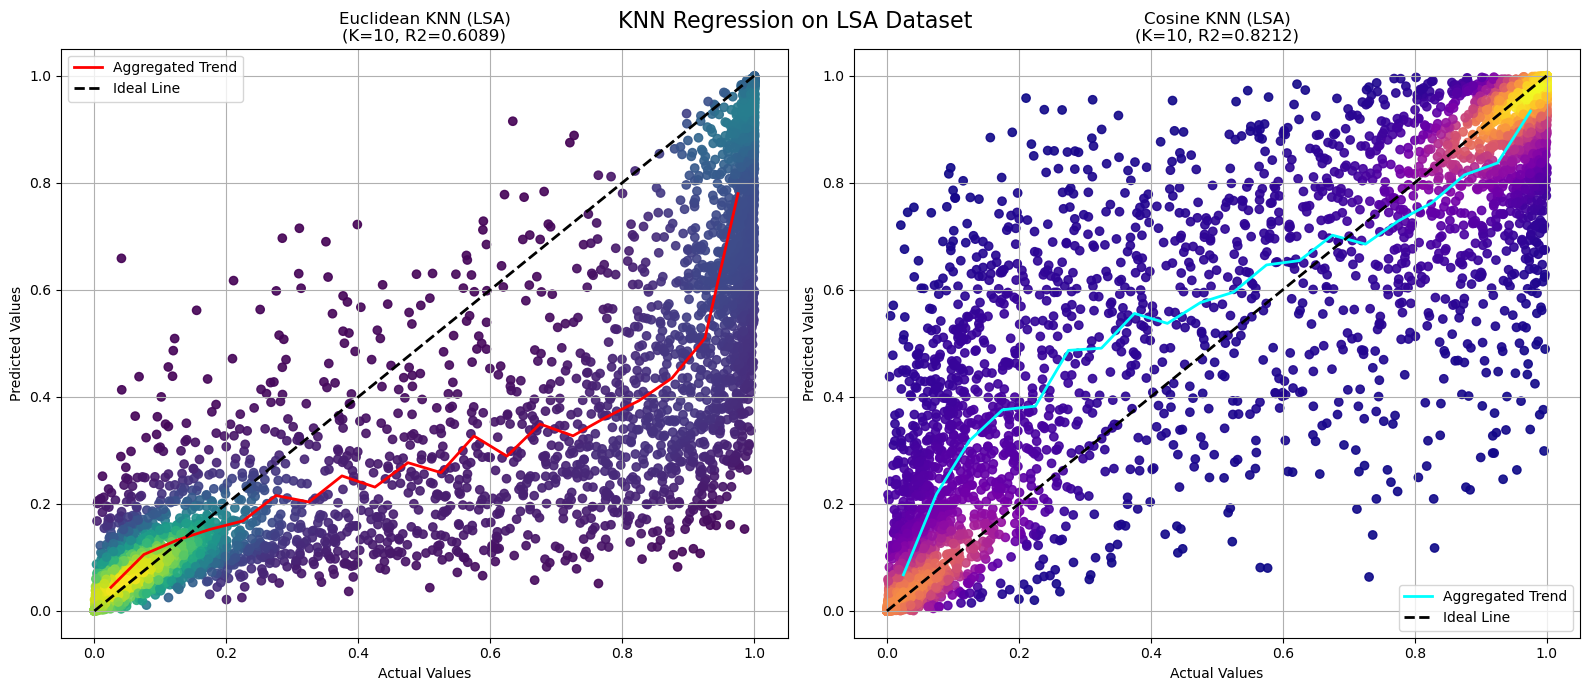

In [5]:
# Load the dataset
data = pd.read_csv('lsa_regression_dataset_logreg.csv')

# Define features and target
X = data.drop(columns=['Problematic_Rate'])
y = data['Problematic_Rate']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of K values to evaluate
k_values = [1, 5, 10, 50, 100, 200, 500, 1000]

# Initialize results dictionary
results = {
    'K': [], 'Metric': [], 'Train_MSE': [], 'Train_R2': [], 'Train_MAE': [],
    'Test_MSE': [], 'Test_R2': [], 'Test_MAE': [], 'Fit_Time': [], 'Test_Time': []
}

# Function to evaluate KNN for a given distance metric
def evaluate_knn(metric_name):
    best_r2 = -np.inf
    best_model = None
    best_predictions = None

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric_name)

        # Measure fit time
        start_fit = time.time()
        knn.fit(X_train, y_train)
        fit_time = time.time() - start_fit

        # Measure test time
        start_test = time.time()
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        test_time = time.time() - start_test

        # Calculate metrics for train and test sets
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Save results
        results['K'].append(k)
        results['Metric'].append(metric_name)
        results['Train_MSE'].append(train_mse)
        results['Train_R2'].append(train_r2)
        results['Train_MAE'].append(train_mae)
        results['Test_MSE'].append(test_mse)
        results['Test_R2'].append(test_r2)
        results['Test_MAE'].append(test_mae)
        results['Fit_Time'].append(fit_time)
        results['Test_Time'].append(test_time)

        # Track the best model
        if test_r2 > best_r2:
            best_r2 = test_r2
            best_model = knn
            best_predictions = y_test_pred

    return best_model, best_predictions

# Evaluate both Euclidean and Cosine KNN
euclidean_knn, euclidean_pred = evaluate_knn('euclidean')
cosine_knn, cosine_pred = evaluate_knn('cosine')

# Display results as a DataFrame
results_df = pd.DataFrame(results)
print("KNN Regressor Performance Comparison (TF-IDF - Euclidean vs Cosine):")
print(results_df)

# Find the best models for Euclidean and Cosine based on R2
euclidean_results = results_df[results_df['Metric'] == 'euclidean']
cosine_results = results_df[results_df['Metric'] == 'cosine']

best_euclidean = euclidean_results.loc[euclidean_results['Test_R2'].idxmax()]
best_cosine = cosine_results.loc[cosine_results['Test_R2'].idxmax()]

print("\nBest Euclidean Model:")
print(best_euclidean)
print("\nBest Cosine Model:")
print(best_cosine)

# Plotting with density-based scatter points
plt.figure(figsize=(16, 7))

# Euclidean plot
plt.subplot(1, 2, 1)
euclidean_bin_centers, euclidean_mean_preds = aggregate_predictions(y_test, euclidean_pred)

# Calculate point density for Euclidean predictions
xy_euclidean = np.vstack([y_test, euclidean_pred])
z_euclidean = gaussian_kde(xy_euclidean)(xy_euclidean)

# Scatter plot with density color mapping
plt.scatter(y_test, euclidean_pred, c=z_euclidean, cmap='viridis', alpha=0.9)
plt.plot(euclidean_bin_centers, euclidean_mean_preds, color='red', label='Aggregated Trend', linewidth=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.title(f'Euclidean KNN (LSA)\n(K={best_euclidean["K"]}, R2={best_euclidean["Test_R2"]:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

# Cosine plot
plt.subplot(1, 2, 2)
cosine_bin_centers, cosine_mean_preds = aggregate_predictions(y_test, cosine_pred)

# Calculate point density for Cosine predictions
xy_cosine = np.vstack([y_test, cosine_pred])
z_cosine = gaussian_kde(xy_cosine)(xy_cosine)

# Scatter plot with density color mapping
plt.scatter(y_test, cosine_pred, c=z_cosine, cmap='plasma', alpha=0.9)
plt.plot(cosine_bin_centers, cosine_mean_preds, color='aqua', label='Aggregated Trend', linewidth=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.title(f'Cosine KNN (LSA)\n(K={best_cosine["K"]}, R2={best_cosine["Test_R2"]:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.suptitle("KNN Regression on LSA Dataset", fontsize=16)
plt.show()

Random Forest Regressor Model:
n_estimators: 100, max_depth: 100
Mean Squared Error (MSE): 0.08350070895157291
R-squared: 0.5171585224263533



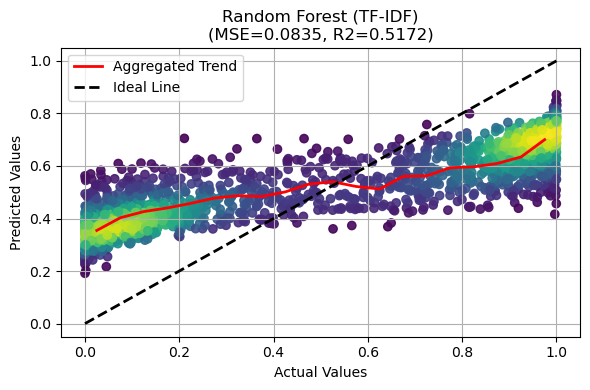

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
data = pd.read_csv('tfidf_regression_dataset_logreg.csv')

# Define features and target
X = data.drop(columns=['Problematic_Rate'])
y = data['Problematic_Rate']

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the fixed parameters
n_estimators = 100
max_depth = 100

# Other fixed parameters
min_samples_split = 5
min_samples_leaf = 10
max_features = 'log2'
bootstrap = True
random_state = 42

# Define the Random Forest Regressor model with the selected hyperparameters
rf_regressor = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    bootstrap=bootstrap,
    random_state=random_state
)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model using MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print out the model and evaluation metrics
print(f"Random Forest Regressor Model:")
print(f"n_estimators: {n_estimators}, max_depth: {max_depth}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}\n")

# Generate aggregated trend data
bin_centers, mean_preds = aggregate_predictions(y_test, y_pred)

# Calculate the point density
xy = np.vstack([y_test, y_pred])
z = gaussian_kde(xy)(xy)

# Create a scatter plot with the density as the color map
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    y_test, y_pred, c=z, cmap='viridis', alpha=0.9)

# Overlay the aggregated trend
plt.plot(bin_centers, mean_preds, color='red', label='Aggregated Trend', linewidth=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')

# Add labels and a title
plt.title(f'Random Forest (TF-IDF)\n(MSE={mse:.4f}, R2={r2:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Random Forest Regressor Model:
n_estimators: 100, max_depth: 100
Mean Squared Error (MSE): 0.0346369196521102
R-squared: 0.80168927104485



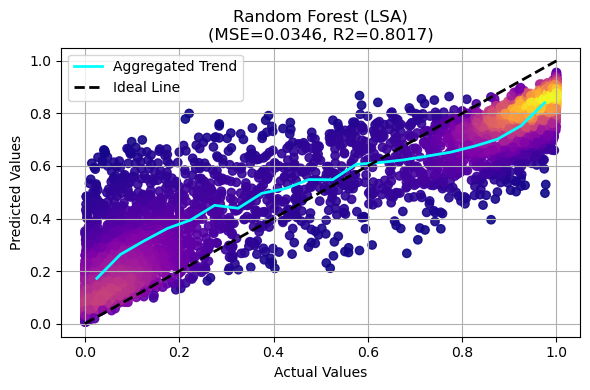

In [7]:
# Load the dataset
data = pd.read_csv('lsa_regression_dataset_logreg.csv')

# Define features and target
X = data.drop(columns=['Problematic_Rate'])
y = data['Problematic_Rate']

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the fixed parameters
n_estimators = 100
max_depth = 100

# Other fixed parameters
min_samples_split = 5
min_samples_leaf = 10
max_features = 'log2'
bootstrap = True
random_state = 42

# Define the Random Forest Regressor model with the selected hyperparameters
rf_regressor = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    bootstrap=bootstrap,
    random_state=random_state
)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model using MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print out the model and evaluation metrics
print(f"Random Forest Regressor Model:")
print(f"n_estimators: {n_estimators}, max_depth: {max_depth}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}\n")

# Generate aggregated trend data
bin_centers, mean_preds = aggregate_predictions(y_test, y_pred)

# Calculate the point density
xy = np.vstack([y_test, y_pred])
z = gaussian_kde(xy)(xy)

# Create a scatter plot with the density as the color map
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    y_test, y_pred, c=z, cmap='plasma', alpha=0.9)

# Overlay the aggregated trend
plt.plot(bin_centers, mean_preds, color='aqua', label='Aggregated Trend', linewidth=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')

# Add labels and a title
plt.title(f'Random Forest (LSA)\n(MSE={mse:.4f}, R2={r2:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np

# Assuming `data` is already loaded in the environment and contains the 'Problematic_Rate' column
y = data['Problematic_Rate']

# Define bins and calculate the count of samples in each bin
bin_edges = np.arange(0, 1.1, 0.1)  # Bin edges from 0 to 1 with step 0.1
bin_counts = pd.cut(y, bins=bin_edges, include_lowest=True).value_counts().sort_index()

# Convert to a DataFrame for better readability
bin_summary = pd.DataFrame({
    'Bin Range': [f"{round(interval.left, 2)} - {round(interval.right, 2)}" for interval in bin_counts.index],
    'Sample Count': bin_counts.values
})

print(bin_summary)

    Bin Range  Sample Count
0  -0.0 - 0.1          6504
1   0.1 - 0.2          1831
2   0.2 - 0.3          1034
3   0.3 - 0.4           753
4   0.4 - 0.5           657
5   0.5 - 0.6           604
6   0.6 - 0.7           636
7   0.7 - 0.8           859
8   0.8 - 0.9          1375
9   0.9 - 1.0          8987
